# Solve GLUE tasks using BERT

BERT can be used to solve many problems in natural language processing. We will fine-tune BERT for many tasks from the GLUE benchmark:

* `CoLA (Corpus of Linguistic Acceptability)`: Is the sentence grammatically correct?

* `SST-2 (Stanford Sentiment Treebank)`: The task is to predict the sentiment of a given sentence.

* `MRPC (Microsoft Research Paraphrase Corpus)`: Determine whether a pair of sentences are semantically equivalent.

* `QQP (Quora Question Pairs2)`: Determine whether a pair of questions are semantically equivalent.

* `MNLI (Multi-Genre Natural Language Inference)`: Given a premise sentence and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral).

* `QNLI(Question-answering Natural Language Inference)`: The task is to determine whether the context sentence contains the answer to the question.

* `RTE(Recognizing Textual Entailment)`: Determine if a sentence entails a given hypothesis or not.

* `WNLI(Winograd Natural Language Inference)`: The task is to predict if the sentence with the pronoun substituted is entailed by the original sentence.

This tutorial contains complete end-to-end code to train these models on a TPU. 

---
---
---
---
In this notebook, we will:

* Load a BERT model from TensorFlow Hub
* Choose one of GLUE tasks and download the dataset
* Preprocess the text
* Fine-tune BERT (examples are given for single-sentence and multi-sentence datasets)
* Save the trained model and use it

> The model developed will be end-to-end. The preprocessing logic will be included in the model itself, making it capable of accepting raw strings as input.

### Setup

We will use a separate model to preprocess text before using it to fine-tune BERT. This model depends on tensorflow/text

We will use the AdamW optimizer from tensorflow/models to fine-tune BERT, which we install as well.

In [ ]:
pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
! pip install -q -U tf-models-official==2.7.0
 
! pip install -U tfds-nightly

In [3]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [4]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [5]:
import os

if os.environ.get('COLAB_TPU_ADDR'):
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


### Select BERT Model

Here we can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available to choose from.

* BERT-Base, Uncased and seven more models with trained weights released by the original BERT authors.
* Small BERTs have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
* ALBERT: four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
* BERT Experts: eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
* Electra has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
* BERT with Talking-Heads Attention and Gated GELU [base, large] has two improvements to the core of the Transformer architecture.

In [6]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Use selected BERT model on example input

This tutorial demonstrates how to do preprocessing as part of the input pipeline for training, using Dataset.map, and then merge it into the model that gets exported for inference. That way, both training and inference can work from raw text inputs, although the TPU itself requires numeric inputs.

TPU requirements aside, it can help performance have preprocessing done asynchronously in an input pipeline (you can learn more in the tf.data performance guide).

This tutorial also demonstrates how to build multi-input models, and how to adjust the sequence length of the inputs to BERT.

In [7]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


Each preprocessing model also provides a method, .bert_pack_inputs(tensors, seq_length), which takes a list of tokens (like tok above) and a sequence length argument. This packs the inputs to create a dictionary of tensors in the format expected by the BERT model.

In [8]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


Here are some details to pay attention to:

* input_mask The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.
* input_type_ids has the same shape as input_mask, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

Next, let's create a preprocessing model that encapsulates all this logic. The model will take strings as input, and return appropriately formatted objects which can be passed to BERT.

In [9]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

#### An example

In [10]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_word_ids', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


Let's take a look at the model's structure, paying attention to the two inputs you just defined.

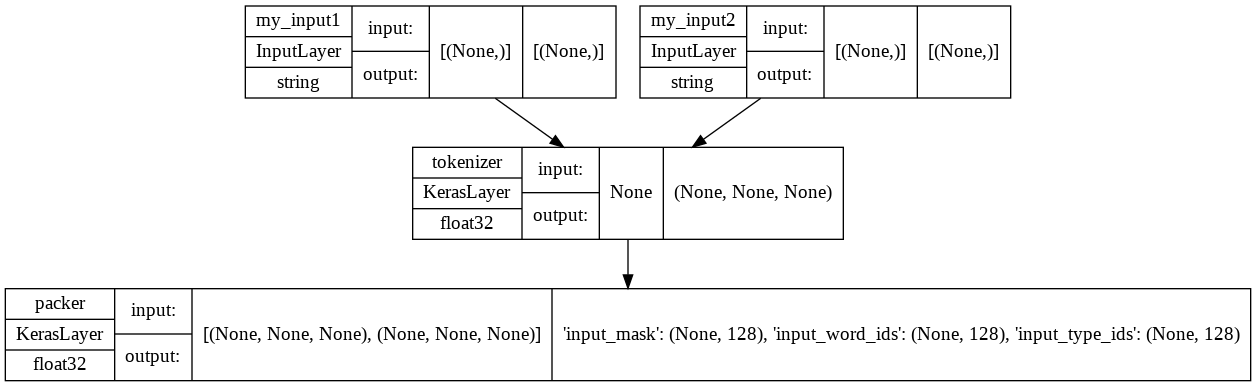

In [11]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

To apply the preprocessing in all the inputs from the dataset, you will use the map function from the dataset. The result is then cached for performance.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size, bert_preprocess_model):
  
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

## Define your model

We are now ready to define the model for sentence or sentence pair classification by feeding the preprocessed inputs through the BERT encoder and putting a linear classifier on top (or other arrangement of layers as you prefer), and using dropout for regularization.

In [13]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

An example

In [14]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.63333416 0.1934526 ]], shape=(1, 2), dtype=float32)


In [15]:
# Here's what the input looks like - 
text_preprocessed

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

## Choose a task from GLUE

You are going to use a TensorFlow DataSet from the GLUE benchmark suite.

Colab lets you download these small datasets to the local filesystem, and the code below reads them entirely into memory, because the separate TPU worker host cannot access the local filesystem of the colab runtime.

For bigger datasets, you'll need to create your own Google Cloud Storage bucket and have the TPU worker read the data from there. You can learn more in the TPU guide.

It's recommended to start with the CoLa dataset (for single sentence) or MRPC (for multi sentence) since these are small and don't take long to fine tune.

In [16]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8551 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/cola/2.0.0.incomplete1P6NA6/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/1043 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/cola/2.0.0.incomplete1P6NA6/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1063 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/cola/2.0.0.incomplete1P6NA6/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



The dataset also determines the problem type (classification or regression) and the appropriate loss function for training.

In [17]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  if glue_task == 'glue/cola':
    metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

## Model Training

`Optimizer` - 

Fine-tuning follows the optimizer set-up from BERT pre-training (as in Classify text with BERT): It uses the AdamW optimizer with a linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5)

In [18]:
sentence_features

['sentence']

In [19]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


267/267 [==============================] - 100s 106ms/step - loss: 0.5448 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.5639 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/3
267/267 [==============================] - 22s 81ms/step - loss: 0.3661 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.5374 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 3/3
267/267 [==============================] - 23s 85ms/step - loss: 0.2555 - MatthewsCorrelationCoefficient: 0.0000e+00 - val_loss: 0.6498 - val_MatthewsCorrelationCoefficient: 0.0000e+00


## Export for inference

At inference time, preprocessing needs to be part of the model (because there is no longer a separate input queue as for training data that does it). Preprocessing is not just computation; it has its own resources (the vocab table) that must be attached to the Keras Model that is saved for export. This final assembly is what will be saved.

In [20]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/glue_cola_bert_en_uncased_L-12_H-768_A-12


## Test the model
The final step is testing the results of your exported model.

Just to make some comparison, let's reload the model and test it using some inputs from the test split from the dataset.

In [21]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

#### Utility methods

In [22]:
def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print('sentence:', test[0].numpy())
    if bert_result_class == 1:
      print('This sentence is acceptable')
    else:
      print('This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print('sentence:', test[0])
    if bert_result_class == 1:
      print('This sentence has POSITIVE sentiment')
    else:
      print('This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Are a paraphrase')
    else:
      print('Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print('question1:', test[0])
    print('question2:', test[1])
    if bert_result_class == 1:
      print('Questions are similar')
    else:
      print('Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print('premise   :', test[0])
    print('hypothesis:', test[1])
    if bert_result_class == 1:
      print('This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print('This premise CONTRADICTS the hypothesis')
    else:
      print('This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print('question:', test[0])
    print('sentence:', test[1])
    if bert_result_class == 1:
      print('The question is NOT answerable by the sentence')
    else:
      print('The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  print('BERT raw results:', bert_result[0])
  print()

In [23]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence: [b"I know the person whose mother's dog died."]
This sentence is acceptable
BERT raw results: tf.Tensor([-2.5136473  3.0051775], shape=(2,), dtype=float32)

sentence: [b'She turned down the side street.']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.6960368  3.2796297], shape=(2,), dtype=float32)

sentence: [b'The idea struck the men all as nonsense.']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.0810292  2.6765568], shape=(2,), dtype=float32)

sentence: [b'I saw kissing Mary.']
This sentence is unacceptable
BERT raw results: tf.Tensor([ 1.9570287 -2.5118392], shape=(2,), dtype=float32)

sentence: [b'As much has happened in the last week as has happened all year.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.720504  2.552202], shape=(2,), dtype=float32)



In the above example, we took as input a sentence and predicted whether the sentence follows English structure or not.

Let's try the approach on other datasets

In [24]:
GLUE_TASK = 'glue/sst2'

Let's use the same BERT models

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3

Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [25]:
tfds_name = 'glue/sst2' 

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/sst2 from TFDS
This dataset has 70042 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/67349 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteWDCSIO/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/872 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteWDCSIO/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1821 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/2.0.0.incompleteWDCSIO/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/sst2 dataset
['negative', 'positive']

sample row 1
b'for the uninitiated plays better on video with the sound '
label: 0 (negative)

sample row 2
b'like a giant commercial for universal studios , where much of the action takes place '
label: 0 (negative)

sample row 3
b'company once again dazzle and delight us '
label: 1 (positive)

sample row 4
b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "
label: 1 (positive)

sample row 5
b', this cross-cultural soap opera is painfully formulaic and stilted . '
label: 0 (negative)



In [ ]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1279/2104 [=================>............] - ETA: 1:04 - loss: 0.3338 - accuracy: 0.8580

### Save the model

In [ ]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

### Load the model

In [ ]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

### Test the model

In [ ]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)